In [157]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import subprocess
import numpy as np
import glob

In [158]:
def savefig(name, **kwargs):
    fn = "{}.pdf".format(name)
    pp = PdfPages(fn)
    pp.savefig(dpi=1200, bbox_inches="tight", **kwargs)
    pp.close()
    print("saving and cropping ", fn)
    subprocess.run(["pdfcrop", fn, fn])

In [159]:
# us -> MHz
reference_frequency_per_time_unit = 2.0E3
TRANSITION_LATENCY = "Transition latency [µs]"
WAIT_LATENCY = "Time since last frequency switch [µs]"
SOURCE_FREQUENCY = "Source Frequency [GHz]"
TARGET_FREQUENCY = "Target Frequency [GHz]"
FREQ_TRANSITION = "Frequency transition [GHz]"

In [160]:
folder = "results/hati"
files_matcher = f"./{folder}/*.txt"

processed_data = pd.DataFrame()
all_data = pd.DataFrame()

for file in glob.glob(files_matcher):
    frequencies, slug = os.path.basename(file).split('-')
    start, target = frequencies.split('_')
    start_ghz = int(start) / 1e6
    target_ghz = int(target) / 1e6

    # filter out too high turbo frequencies
    if target_ghz > 2.9 or start_ghz > 2.9:
        continue

    try:
        data = pd.read_csv(file, sep='\t',comment='#')
        print(data)
    except:
        continue
    data=data.rename(columns={"Change time (with write) [cycles]": TRANSITION_LATENCY, "Time since last frequency change request [cycles]": WAIT_LATENCY})
    data[TRANSITION_LATENCY] = data[TRANSITION_LATENCY] / reference_frequency_per_time_unit
    data[WAIT_LATENCY] = data[WAIT_LATENCY] / reference_frequency_per_time_unit

    # filter invalid measurement values
    data=data[data[TRANSITION_LATENCY]>0]

    processed_data = pd.concat([processed_data, pd.DataFrame([
        {'valids': len(data),
         'median_<1ms': np.median(data[data[WAIT_LATENCY] < 1000][TRANSITION_LATENCY].quantile(0.5)),
         'median_>1ms': np.median(data[data[WAIT_LATENCY] > 1000][TRANSITION_LATENCY].quantile(0.5)),
         'median': np.median(data[TRANSITION_LATENCY].quantile(0.5)),
         '1percentQuantile': data[TRANSITION_LATENCY].quantile(0.01),
         '95percentQuantile': data[TRANSITION_LATENCY].quantile(0.95),
         '99percentQuantile': data[TRANSITION_LATENCY].quantile(0.99),
         SOURCE_FREQUENCY: start_ghz,
         TARGET_FREQUENCY: target_ghz}
    ])])

    data[SOURCE_FREQUENCY] = start_ghz
    data[TARGET_FREQUENCY] = target_ghz
    data[FREQ_TRANSITION] = f"{start_ghz}GHz -> {target_ghz}GHz"
    all_data = pd.concat([all_data, data])

processed_data

     Change time (with write) [cycles]  Change time [cycles]  \
0                              1014672                957596   
1                              1393902               1369920   
2                               958914                933810   
3                              1704904               1677266   
4                              1585844               1561330   
..                                 ...                   ...   
995                            1184512               1160524   
996                            2094392               2067212   
997                            1471488               1447976   
998                            1317342               1293074   
999                            1342870               1318174   

     Write cost [cycles]  Wait time [us]  \
0                  57076            3567   
1                  23982            4812   
2                  25104             907   
3                  27638            3036   
4          

,valids,median_<1ms,median_>1ms,median,1percentQuantile,95percentQuantile,99percentQuantile,Source Frequency [GHz],Target Frequency [GHz]
0,884,591.9635,740.3255,731.3560,206.35811,1005.06805,1085.96217,1.6,2.4
0,1000,592.3930,781.7620,765.6515,194.73829,1081.07340,1884.85051,1.3,2.2
0,1000,590.6710,590.7070,590.6890,106.50169,649.40535,696.90649,1.5,0.9
0,923,591.0490,589.3720,589.4890,99.13398,641.60510,681.62060,1.7,1.6
0,995,593.3915,591.2320,591.4060,106.81584,642.04180,685.82314,1.5,1.6
...,...,...,...,...,...,...,...,...,...
0,1000,543.2110,813.1880,794.7455,191.59995,1063.37625,1122.28487,1.1,2.1
0,990,587.3070,587.0200,587.0485,103.97607,640.25095,712.07324,2.9,2.1
0,986,589.3600,587.6290,587.7860,106.62555,649.24400,1387.92805,2.0,1.8
0,934,593.7370,589.7715,590.0570,102.76194,649.03875,710.11447,2.1,0.8


In [161]:
all_data.reset_index()
all_data

,Transition latency [µs],Change time [cycles],Write cost [cycles],Wait time [us],Time since last frequency switch [µs],Time since last frequency change [cycles],Detected frequency change timestamp [cycles],Source Frequency [GHz],Target Frequency [GHz],Frequency transition [GHz]
0,507.336,957596,57076,3567,167883.769,335630218,1122197290935235,1.6,2.4,1.6GHz -> 2.4GHz
1,696.951,1369920,23982,4812,5549.597,11315538,1122197303652401,1.6,2.4,1.6GHz -> 2.4GHz
2,479.457,933810,25104,907,1644.706,3069936,1122197308121343,1.6,2.4,1.6GHz -> 2.4GHz
3,852.452,1677266,27638,3036,3557.247,8074904,1122197317161267,1.6,2.4,1.6GHz -> 2.4GHz
4,792.922,1561330,24514,4996,5465.168,11875216,1122197329898133,1.6,2.4,1.6GHz -> 2.4GHz
...,...,...,...,...,...,...,...,...,...,...
992,587.337,1156090,18584,4240,5076.951,9857738,1124943183457499,2.6,1.8,2.6GHz -> 1.8GHz
993,590.688,1165530,15846,4037,4792.362,9463326,1124943194489995,2.6,1.8,2.6GHz -> 1.8GHz
995,588.122,1159824,16420,120,1179.239,1610000,1124943208598745,2.6,1.8,2.6GHz -> 1.8GHz
998,494.620,971414,17826,4914,5863.841,11024214,1124943240161615,2.6,1.8,2.6GHz -> 1.8GHz


In [162]:
all_data_random_sample = all_data.sample(frac=.10)
all_data_random_sample

,Transition latency [µs],Change time [cycles],Write cost [cycles],Wait time [us],Time since last frequency switch [µs],Time since last frequency change [cycles],Detected frequency change timestamp [cycles],Source Frequency [GHz],Target Frequency [GHz],Frequency transition [GHz]
214,512.688,995794,29582,2108,2697.260,5644606,1120788976744389,1.1,2.8,1.1GHz -> 2.8GHz
149,746.389,1470586,22192,1094,1809.662,3940288,1122996700662209,1.9,2.1,1.9GHz -> 2.1GHz
238,287.243,546300,28186,1582,2422.893,4112756,1120929042970145,1.2,1.0,1.2GHz -> 1.0GHz
648,711.463,1396890,26036,1476,2242.041,4725184,1121344648177051,1.3,2.5,1.3GHz -> 2.5GHz
94,1046.430,2069574,23286,1531,2269.185,5451610,1122180621165033,1.6,2.2,1.6GHz -> 2.2GHz
...,...,...,...,...,...,...,...,...,...,...
563,478.473,818420,138526,4659,5382.204,10625516,1121272824129135,1.3,1.7,1.3GHz -> 1.7GHz
520,593.229,1166770,19688,1343,2341.989,4084314,1124035005643529,2.3,1.0,2.3GHz -> 1.0GHz
692,539.563,1055490,23636,4911,5603.402,11184374,1122365012154031,1.7,1.1,1.7GHz -> 1.1GHz
175,828.653,1621568,35738,2537,3381.788,7207542,1120214037863009,0.9,2.9,0.9GHz -> 2.9GHz


saving and cropping  ../../thesis/fig/ftalat_valids_hati.pdf
PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../../thesis/fig/ftalat_valids_hati.pdf'.


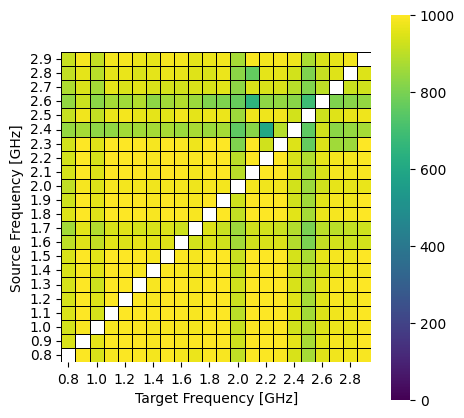

In [163]:
plt.rcParams['figure.figsize'] = 5,5

ax = sns.heatmap(data=processed_data.pivot(index=SOURCE_FREQUENCY, columns=TARGET_FREQUENCY, values="valids"), vmin=0, square=True, cmap="viridis", linecolor="black", linewidths=0.5)
ax.invert_yaxis()
savefig(f"../../thesis/fig/ftalat_valids_hati")

saving and cropping  ../../thesis/fig/ftalat_median_hati.pdf
PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../../thesis/fig/ftalat_median_hati.pdf'.


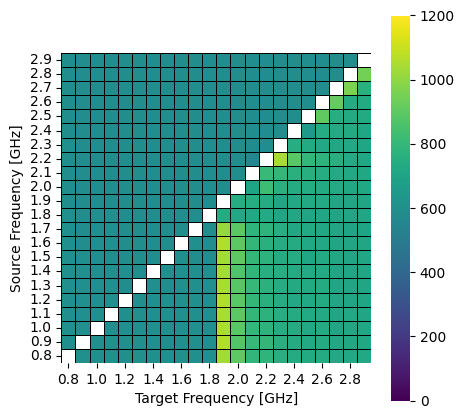

In [164]:
plt.rcParams['figure.figsize'] = 5,5

ax = sns.heatmap(data=processed_data.pivot(index=SOURCE_FREQUENCY, columns=TARGET_FREQUENCY, values="median"), vmin=0, vmax=1200, square=True, cmap="viridis", linecolor="black", linewidths=0.5)
ax.invert_yaxis()
savefig(f"../../thesis/fig/ftalat_median_hati")

saving and cropping  ../../thesis/fig/ftalat_median_<1ms_hati.pdf
PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../../thesis/fig/ftalat_median_<1ms_hati.pdf'.


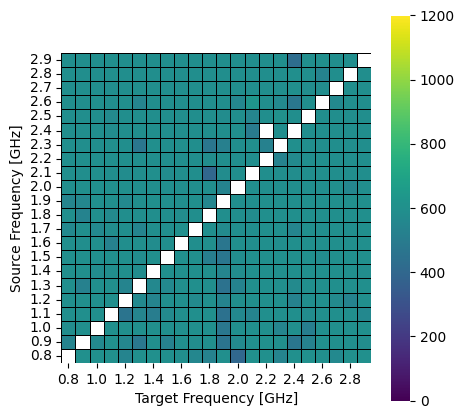

In [165]:
plt.rcParams['figure.figsize'] = 5,5

ax = sns.heatmap(data=processed_data.pivot(index=SOURCE_FREQUENCY, columns=TARGET_FREQUENCY, values="median_<1ms"), vmin=0, vmax=1200, square=True, cmap="viridis", linecolor="black", linewidths=0.5)
ax.invert_yaxis()
savefig(f"../../thesis/fig/ftalat_median_<1ms_hati")

saving and cropping  ../../thesis/fig/ftalat_median_>1ms_hati.pdf
PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../../thesis/fig/ftalat_median_>1ms_hati.pdf'.


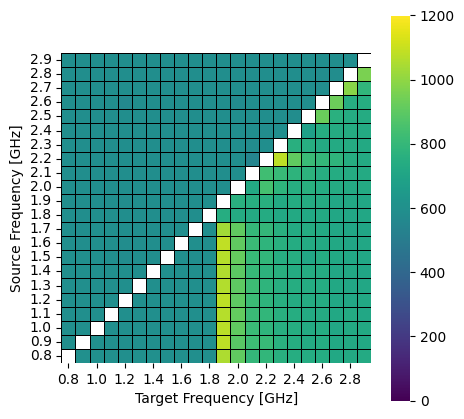

In [166]:
plt.rcParams['figure.figsize'] = 5,5

ax = sns.heatmap(data=processed_data.pivot(index=SOURCE_FREQUENCY, columns=TARGET_FREQUENCY, values="median_>1ms"), vmin=0, vmax=1200, square=True, cmap="viridis", linecolor="black", linewidths=0.5)
ax.invert_yaxis()
savefig(f"../../thesis/fig/ftalat_median_>1ms_hati")

saving and cropping  ../../thesis/fig/ftalat_1percentQuantile_hati.pdf
PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../../thesis/fig/ftalat_1percentQuantile_hati.pdf'.


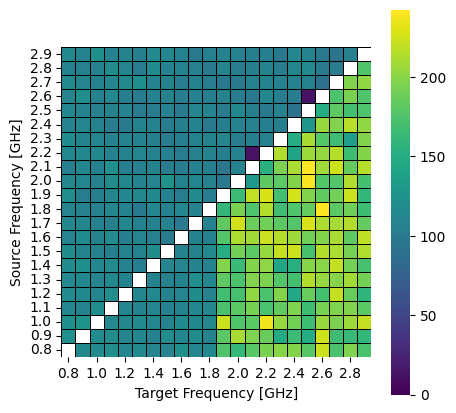

In [167]:
plt.rcParams['figure.figsize'] = 5,5

ax = sns.heatmap(data=processed_data.pivot(index=SOURCE_FREQUENCY, columns=TARGET_FREQUENCY, values="1percentQuantile"), vmin=0, square=True, cmap="viridis", linecolor="black", linewidths=0.5)
ax.invert_yaxis()
savefig(f"../../thesis/fig/ftalat_1percentQuantile_hati")

saving and cropping  ../../thesis/fig/ftalat_95percentQuantile_hati.pdf
PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../../thesis/fig/ftalat_95percentQuantile_hati.pdf'.


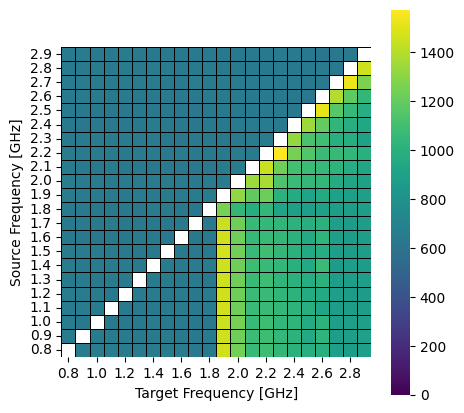

In [168]:
plt.rcParams['figure.figsize'] = 5,5

ax = sns.heatmap(data=processed_data.pivot(index=SOURCE_FREQUENCY, columns=TARGET_FREQUENCY, values="95percentQuantile"), vmin=0, square=True, cmap="viridis", linecolor="black", linewidths=0.5)
ax.invert_yaxis()
savefig(f"../../thesis/fig/ftalat_95percentQuantile_hati")

saving and cropping  ../../thesis/fig/ftalat_99percentQuantile_hati.pdf
PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../../thesis/fig/ftalat_99percentQuantile_hati.pdf'.


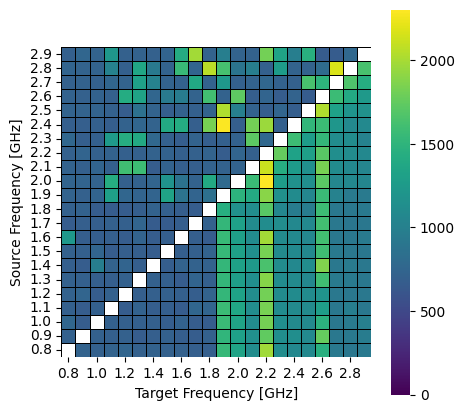

In [169]:
plt.rcParams['figure.figsize'] = 5,5

ax = sns.heatmap(data=processed_data.pivot(index=SOURCE_FREQUENCY, columns=TARGET_FREQUENCY, values="99percentQuantile"), vmin=0, square=True, cmap="viridis", linecolor="black", linewidths=0.5)
ax.invert_yaxis()
savefig(f"../../thesis/fig/ftalat_99percentQuantile_hati")

In [170]:
col_order = [1.8, 1.9, 2.0, 2.1]

In [171]:
filtered_data = all_data
filtered_data = filtered_data[filtered_data[SOURCE_FREQUENCY] == 1.2]
filtered_data = filtered_data[filtered_data[TARGET_FREQUENCY] >= 1.8]
filtered_data = filtered_data[filtered_data[TARGET_FREQUENCY] <= 2.1]
filtered_data

,Transition latency [µs],Change time [cycles],Write cost [cycles],Wait time [us],Time since last frequency switch [µs],Time since last frequency change [cycles],Detected frequency change timestamp [cycles],Source Frequency [GHz],Target Frequency [GHz],Frequency transition [GHz]
0,1050.163,2049112,51214,3567,208799.107,418342858,1120996973149527,1.2,1.9,1.2GHz -> 1.9GHz
1,639.307,1248474,30140,4812,5592.693,11277130,1120996985879755,1.2,1.9,1.2GHz -> 1.9GHz
2,1232.002,2432400,31604,907,1691.178,4653594,1120996991987059,1.2,1.9,1.2GHz -> 1.9GHz
3,781.145,1528686,33604,3036,3814.605,8009600,1120997001439241,1.2,1.9,1.2GHz -> 1.9GHz
4,960.944,1891976,29912,4996,5503.314,12289358,1120997014628827,1.2,1.9,1.2GHz -> 1.9GHz
...,...,...,...,...,...,...,...,...,...,...
995,594.820,1160254,29386,120,877.033,1804832,1121023750079735,1.2,2.1,1.2GHz -> 2.1GHz
996,762.076,1494522,29630,2891,3666.578,7680152,1121023759192127,1.2,2.1,1.2GHz -> 2.1GHz
997,734.230,1440428,28032,3402,4105.729,8646930,1121023769116349,1.2,2.1,1.2GHz -> 2.1GHz
998,588.813,1149200,28426,4914,5639.238,11380962,1121023781817451,1.2,2.1,1.2GHz -> 2.1GHz


saving and cropping  ../../thesis/fig/ftalat_scatter_wait_transition_latency_hati.pdf
PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../../thesis/fig/ftalat_scatter_wait_transition_latency_hati.pdf'.


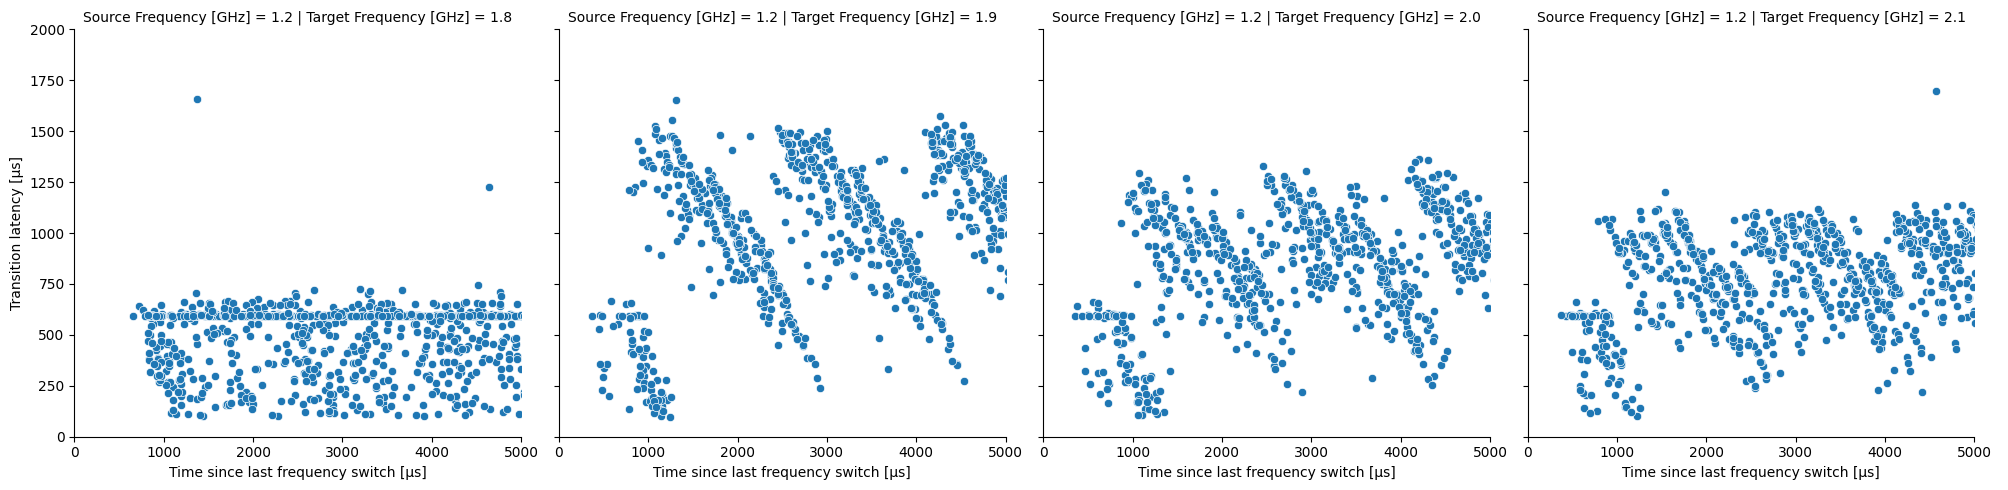

In [172]:
g = sns.FacetGrid(filtered_data, col=TARGET_FREQUENCY,  row=SOURCE_FREQUENCY, height=5, col_order=col_order, ylim=(0, 2000), xlim=(0, 5000))
g.map(sns.scatterplot, WAIT_LATENCY, TRANSITION_LATENCY)
g.add_legend()
savefig(f"../../thesis/fig/ftalat_scatter_wait_transition_latency_hati")

saving and cropping  ../../thesis/fig/ftalat_distribution_transition_latency_hati.pdf
PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../../thesis/fig/ftalat_distribution_transition_latency_hati.pdf'.


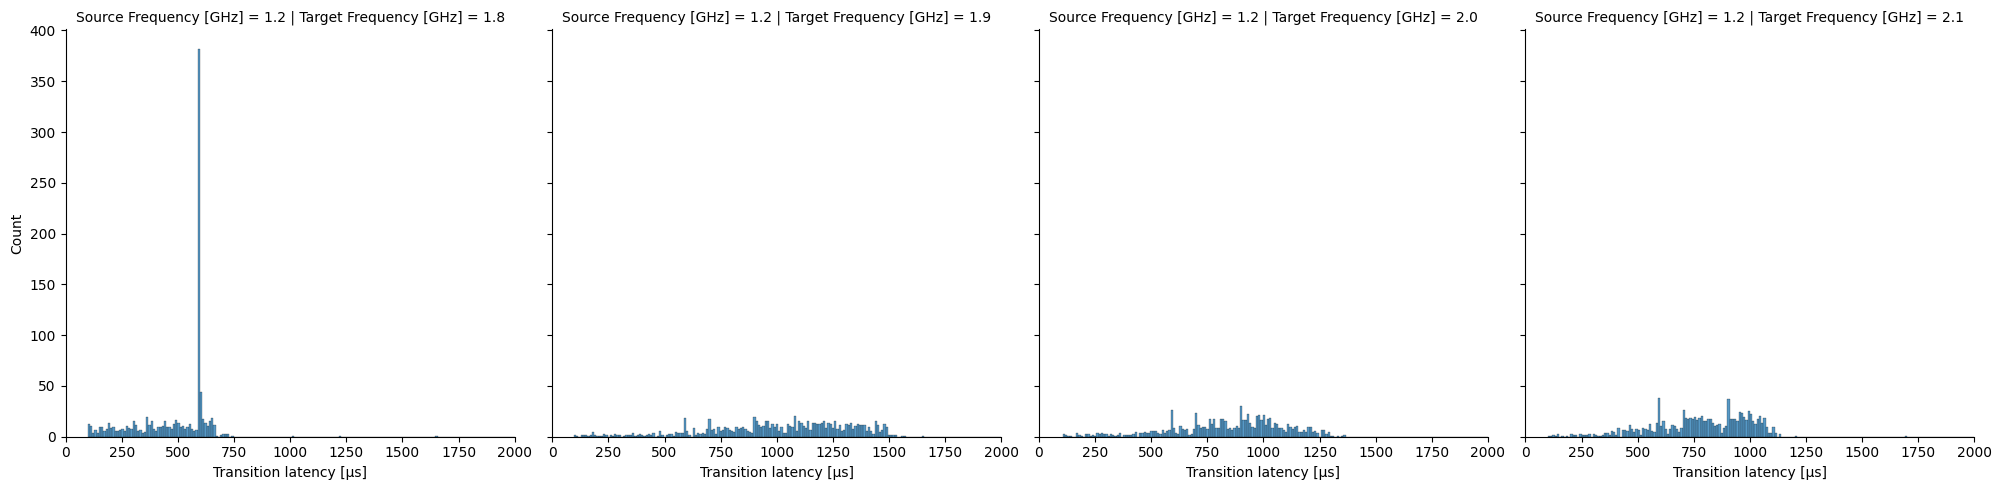

In [173]:
g = sns.FacetGrid(filtered_data, col=TARGET_FREQUENCY, row=SOURCE_FREQUENCY, height=5, col_order=col_order, xlim=(0, 2000))
g.map(sns.histplot, TRANSITION_LATENCY, binwidth=10)
g.add_legend()
savefig(f"../../thesis/fig/ftalat_distribution_transition_latency_hati")